# 1-D Inviscid Burgers Experiment:  Predicting Quantites of Interest

This notebook compares the methods of Active Subspaces and Active Manifolds for the approximation of scalar functions which depend on the solution of the parameterized 1-D Inviscid Burgers equation:

$$ \begin{align}\label{eq:mainsystem}
\begin{split}
    w_t + \frac{1}{2}\left(w^2\right)_x &= 0.02e^{\mu_2 x}, \\
    w(0, t, \boldsymbol{\mu}) &= \mu_1, \\
    w(x,0,\boldsymbol{\mu}) &= 1.
\end{split}
\end{align} $$

In particular, the quantities of interest are 

$$ \begin{align*}
    Q_2(t, \boldsymbol\mu) &= \frac{1}{2}\int_0^t \int_0^{100} w(x,\tau,\boldsymbol\mu)^2 \,dx\,d\tau, \\
    Q_3(t, \boldsymbol\mu) &= \frac{1}{2}\int_0^t w(100, \tau, \boldsymbol\mu)^2\,d\tau,
\end{align*} $$

where $(t, \mu_1, \mu_2) \in [25, 45] \times [4.25, 5.5] \times [0.015, 0.03]$ and $x\in [0,100]$.  The goal is to use sample values of $Q_2, Q_3$ obtained from simulations of the above IVP to train an approximation to these functions at any $(t, \boldsymbol\mu)$ in parameter space.

In [18]:
# Import packages and point to installation of burgers.py, numethod.py, and the AS module.
# (You will have to adjust this for your installation.)

# Path stuff
import sys
sys.path.insert(0, "/Users/anthonygruber/Desktop/Projects/AMv2/src")

# Standard packages
import numpy as np
import matplotlib.pyplot as plt

# For 3D plots
from mpl_toolkits import mplot3d

# Handwritten code
import numethod as nm
import burgers as bg
import active_subspaces as ac

### Create and preprocess initial mesh data

In [19]:
# Number of Samples (Use 6 or 7, using 6 omits the 1000 point data set)
num = 6

# Initial mesh data
points = [0, 0, 0, 0, 0, 0, 0]
np.random.seed(0) # for reproducibility
points[6] = np.random.uniform( -1, 1, (1000, 3) )
points[5] = np.random.uniform( -1, 1, (500, 3) )
points[4] = np.random.uniform( -1, 1, (200, 3) )
points[3] = np.random.uniform( -1, 1, (100, 3) )
points[2] = np.random.uniform( -1, 1, (50, 3) )
points[1] = np.random.uniform( -1, 1, (25, 3) )
points[0] = np.random.uniform( -1, 1, (10, 3) )

# Upper and Lower bounds for parameters, taken from Carlberg paper
UBs = np.array( [45, 5.5, 0.03] )
LBs = np.array( [25, 4.25, 0.015] )

# Linear scaling to appropriate range
nuPoints = np.zeros_like(points)

for i in range(num):
  nuPoints[i] = LBs + 0.5 * (UBs - LBs) * (1 + points[i])

### Sample and collect the values of $Q_2, Q_3$ and their gradients.  Note that $Q_3$ is "QthrA" in code.


In [20]:
# Sample Q and gradQ values over parameter space
data = np.zeros_like(points)

for i in range(num):
  data[i] = map( lambda x: bg.burgers( 2, 256, 2000, nuPoints[i][x, 0], 1,
                                      nuPoints[i][x, 1:], False)[2:], range( len(nuPoints[i]) ) )

# Separate data appropriately
Qtwo = np.zeros_like(points)
QthrA = np.zeros_like(points)
gradQtwo = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]
gradQthrA = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]
nuGradsTwo = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]
nuGradsThrA = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]

for i in range(num):
  Qtwo[i] = np.array( [ data[i][j][0] for j in range( len(data[i]) ) ] )
  gradQtwo[i] = [ data[i][j][1] for j in range( len(data[i]) ) ]
  QthrA[i] = np.array( [ data[i][j][2] for j in range( len(data[i]) ) ] )
  gradQthrA[i] = [ data[i][j][3] for j in range( len(data[i]) ) ]

# Chain rule to get appropriate gradients in [-1,1]^3
for i in range(num):
  nuGradsTwo[i] = 0.5 * (UBs - LBs) * gradQtwo[i]
  nuGradsThrA[i] = 0.5 * (UBs - LBs) * gradQthrA[i]

## Comparison on $Q_2$ 

Results are given in blocks, first AM then AS.  

Note that AM is roughly ~10x more accurate even if a 2-D Active Subspace is used.

In [21]:
# Main routine comparing AM and AS -- first on Q2. 
# Fourth input to nm.subspEx gives dimension of AS -- this can be tweaked.
for i in range(num):
    print( 'The number of samples is %i' %len(points[i]) )
    nm.manifoldEx( points[i], Qtwo[i], nuGradsTwo[i],
                  0.1, 0.2, nm.get_random_init_pt(3, 0), 0, False )
    
    nm.subspEx( points[i], Qtwo[i], nuGradsTwo[i], 2, 0, 0.2, False )
    print(" ")


The number of samples is 10
The Relative L1 Error is 0.654658%
The Relative L2 Error is 0.746433%
The dimension of the Active Subspace is 2
The Relative L1 Error is 3.091450%
The Relative L2 Error is 4.017273%
 
The number of samples is 25
The Relative L1 Error is 0.836447%
The Relative L2 Error is 1.171768%
The dimension of the Active Subspace is 2
The Relative L1 Error is 1.150285%
The Relative L2 Error is 1.481374%
 
The number of samples is 50
The Relative L1 Error is 0.189281%
The Relative L2 Error is 0.224345%
The dimension of the Active Subspace is 2
The Relative L1 Error is 0.570163%
The Relative L2 Error is 0.691853%
 
The number of samples is 100
The Relative L1 Error is 0.238229%
The Relative L2 Error is 0.329978%
The dimension of the Active Subspace is 2
The Relative L1 Error is 0.585729%
The Relative L2 Error is 0.704143%
 
The number of samples is 200
The Relative L1 Error is 0.136798%
The Relative L2 Error is 0.189257%
The dimension of the Active Subspace is 2
The Relati

### Visualization of AM and 1-dimensional AS for 500 point data set.  

First plot is $Q_2$ values along the AM.  Note the monotonic increase consistent with theory.

Second plot is magnitude of eigenvalues in the AS covariance matrix.  
The gap indicates a 1-D active subspace is reasonable.

Third plot is the radial basis approximation trained on the AS, with bootstrap replicates.

The Relative L1 Error is 0.102914%
The Relative L2 Error is 0.147790%


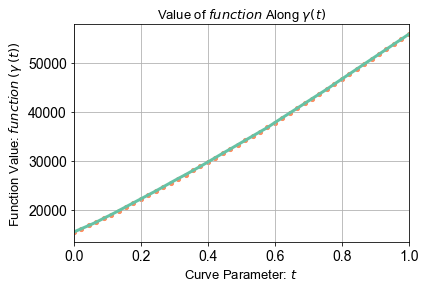

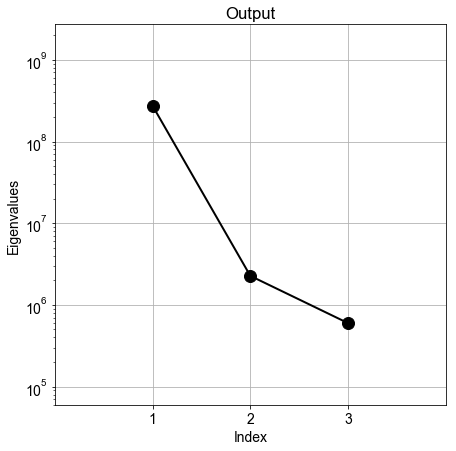

The dimension of the Active Subspace is 1
The Relative L1 Error is 1.701627%
The Relative L2 Error is 1.942984%


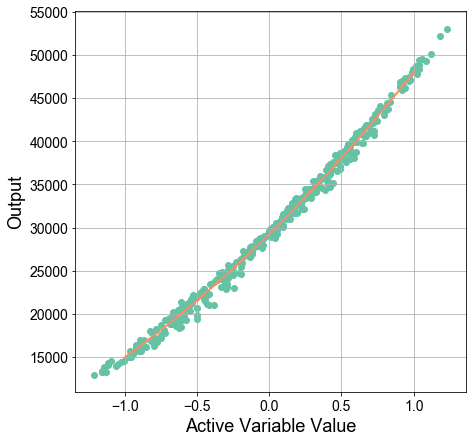

In [22]:
nm.manifoldEx( points[5], Qtwo[5], nuGradsTwo[5], 0.05,
              0.2, nm.get_random_init_pt(3, 0), 0 )

nm.subspEx( points[5], Qtwo[5], nuGradsTwo[5], 1, 0, 0.2 )

### Visualization of AM through the domain

A straightforward plot of the AM through $(t, \boldsymbol\mu)$-space.

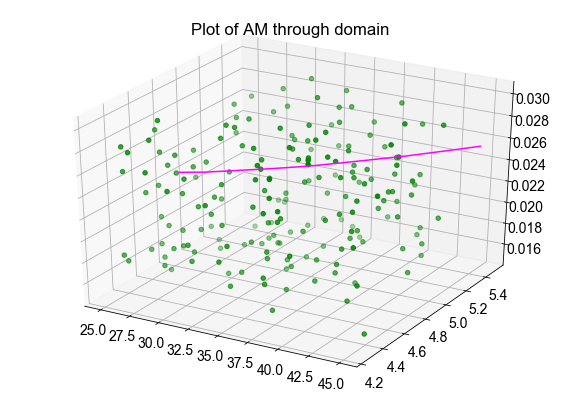

In [23]:
am, fvals = nm.build_AM_from_data( nm.get_random_init_pt(3, 0), points[4], Qtwo[4], nuGradsTwo[4], 0.05)
nuAM = LBs + 0.5 * (UBs - LBs) * (1 + am)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D( nuPoints[4][:,0], nuPoints[4][:,1], nuPoints[4][:,2], color = "green")
ax.plot(nuAM[:,0], nuAM[:,1], nuAM[:,2], color = "magenta", linestyle = "-")
plt.title("Plot of AM through domain")
plt.show()

### Visualization of Coordinates and Sensitivities along the AM.

It can be nice to visualize the change in parameter values, as well as how the derivatives change in magnitude along the AM.

The striation here indicates a clear dominance of the final time in controlling the value of $Q_2.$

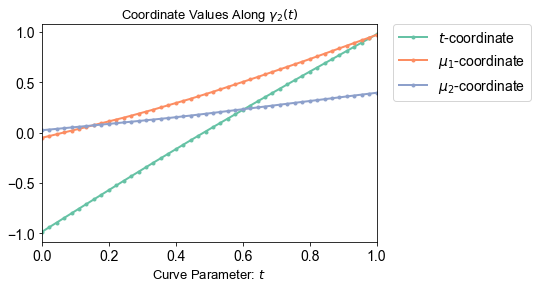

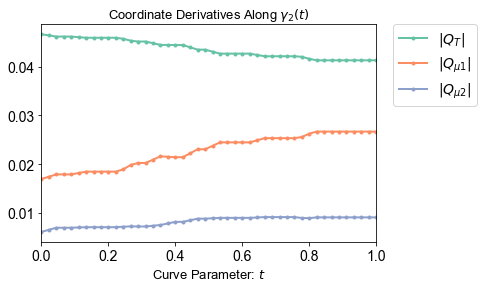

In [24]:
# Coordinate Plot
am, fvals = nm.build_AM_from_data( nm.get_random_init_pt(3, 0),
                                  points[5], Qtwo[5], nuGradsTwo[5], 0.05)

nuAM = LBs + 0.5 * (UBs - LBs) * (1 + am)

numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Values Along $\gamma_2(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues, am[:,0], '-o', c='#66c2a5',
         label = r'$t$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,1], '-o', c='#fc8d62',
         label = r'$\mu_1$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,2], '-o', c='#8da0cb',
         label = r'$\mu_2$-coordinate', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()

# Derivative plot
am, fvals = nm.build_AM_from_data( nm.get_random_init_pt(3, 0),
                                  points[5], Qtwo[5], nuGradsTwo[5], 0.05)

nuAM = LBs + 0.5 * (UBs - LBs) * (1 + am)

numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Derivatives Along $\gamma_2(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues,np.abs(np.gradient(am[:,0])), '-o', c='#66c2a5',
         label = r'$|Q_T|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,1])), '-o', c='#fc8d62',
         label = r'$|Q_{\mu1}|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,2])), '-o', c='#8da0cb',
         label = r'$|Q_{\mu2}|$', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()

## Comparison on $Q_3$ 

Results are given in blocks, first AM then AS.

In [25]:
# Main routine comparing AM and AS -- now on Q3alt
# Fourth input to nm.subspEx gives dimension of AS -- this can be tweaked.
for i in range(num):
    print( 'The number of samples is %i' %len(points[i]) )
    nm.manifoldEx( points[i], QthrA[i], nuGradsThrA[i], 0.1,
                  0.2, nm.get_random_init_pt(3, 0), 0, False )
    
    nm.subspEx( points[i], QthrA[i], nuGradsThrA[i], 2, 0, 0.2, False )
    print(" ")

The number of samples is 10
The Relative L1 Error is 1.258959%
The Relative L2 Error is 1.355597%
The dimension of the Active Subspace is 2
The Relative L1 Error is 8.239617%
The Relative L2 Error is 8.333306%
 
The number of samples is 25
The Relative L1 Error is 2.617042%
The Relative L2 Error is 3.064222%
The dimension of the Active Subspace is 2
The Relative L1 Error is 4.603886%
The Relative L2 Error is 4.973595%
 
The number of samples is 50
The Relative L1 Error is 0.514238%
The Relative L2 Error is 0.745659%
The dimension of the Active Subspace is 2
The Relative L1 Error is 3.074898%
The Relative L2 Error is 3.386758%
 
The number of samples is 100
The Relative L1 Error is 1.253654%
The Relative L2 Error is 2.095266%
The dimension of the Active Subspace is 2
The Relative L1 Error is 3.878808%
The Relative L2 Error is 4.435402%
 
The number of samples is 200
The Relative L1 Error is 0.361867%
The Relative L2 Error is 0.612954%
The dimension of the Active Subspace is 2
The Relati

### Visualization of AM and 1-dimensional AS for 500 point data set.  

Plots are same as before.

The Relative L1 Error is 0.279471%
The Relative L2 Error is 0.506059%


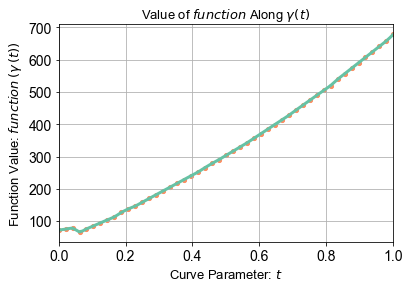

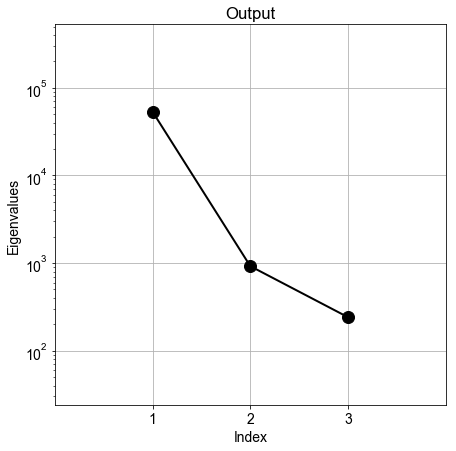

The dimension of the Active Subspace is 1
The Relative L1 Error is 3.943990%
The Relative L2 Error is 4.275052%


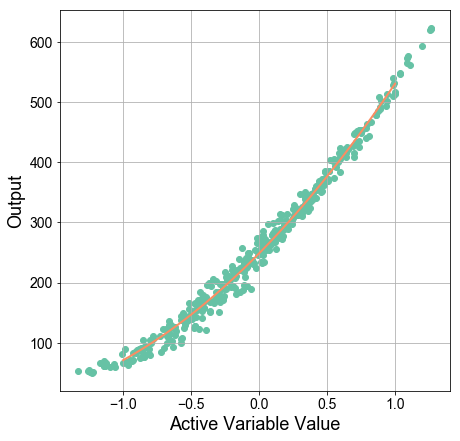

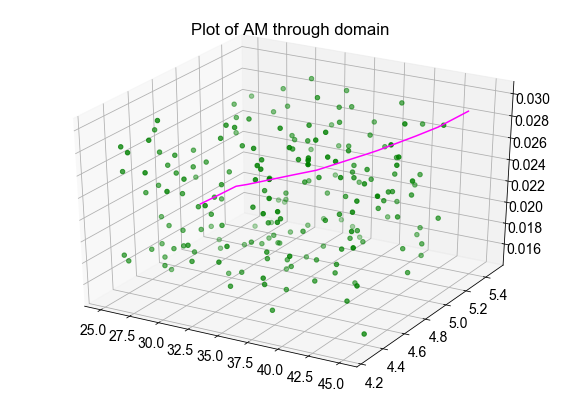

In [26]:
# Visualize the AM and AS for one set -- Q3alt
nm.manifoldEx( points[5], QthrA[5], nuGradsThrA[5], 0.05,
              0.2, nm.get_random_init_pt(3, 0), 0 )

nm.subspEx( points[5], QthrA[5], nuGradsThrA[5], 1, 0, 0.2 )

# Visualize the AM through the 3D domain.
am, fvals = nm.build_AM_from_data( nm.get_random_init_pt(3, 0), points[4], QthrA[4], nuGradsThrA[4], 0.05)

nuAM = LBs + 0.5 * (UBs - LBs) * (1 + am)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D( nuPoints[4][:,0], nuPoints[4][:,1], nuPoints[4][:,2], color = "green")
ax.plot(nuAM[:,0], nuAM[:,1], nuAM[:,2], color = "magenta", linestyle = "-")
plt.title("Plot of AM through domain")
plt.show()

### Visualization of coordinates and sensitivities along the AM.

Once again, final time is the most important to the function value.

On the other hand, $\mu_2$ increases in importance along the AM, almost catching up to $t$.

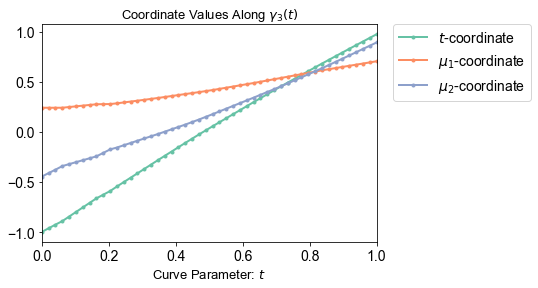

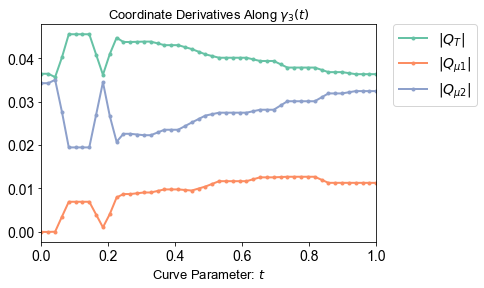

In [27]:
am, fvals = nm.build_AM_from_data( nm.get_random_init_pt(3, 0),
                                  points[5], QthrA[5], nuGradsThrA[5], 0.05)

nuAM = LBs + 0.5 * (UBs - LBs) * (1 + am)

# Coordinate Plot
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Values Along $\gamma_3(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues, am[:,0], '-o', c='#66c2a5',
         label = r'$t$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,1], '-o', c='#fc8d62',
         label = r'$\mu_1$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,2], '-o', c='#8da0cb',
         label = r'$\mu_2$-coordinate', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()

# Derivative Plot
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Derivatives Along $\gamma_3(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues,np.abs(np.gradient(am[:,0])), '-o', c='#66c2a5',
         label = r'$|Q_T|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,1])), '-o', c='#fc8d62',
         label = r'$|Q_{\mu1}|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,2])), '-o', c='#8da0cb',
         label = r'$|Q_{\mu2}|$', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()

## Experiment with parameter influence on $Q_2$.

To address Max's questions, we consider a transformation $\mu_i \mapsto \varepsilon_i\mu_i$ where $\varepsilon_i$ is some small parameter and $i = 1,2$.  The expectation is that the Active Manifold adjusts so that it lies near a subspace where $\mu_i$ is constant.

In either case, this behavior is observed.

### With small $\mu_1$.

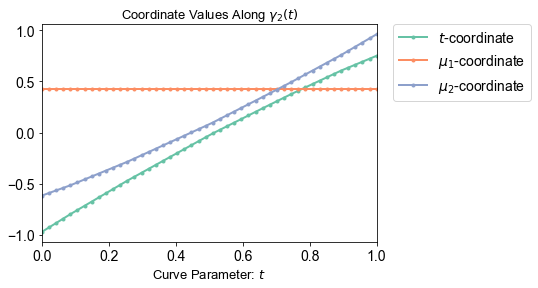

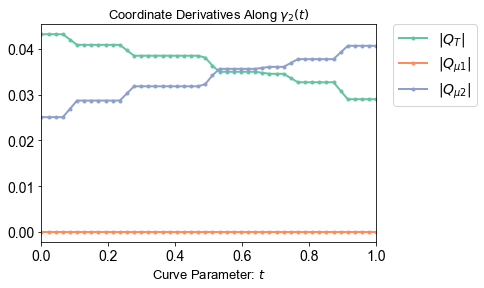

In [28]:
num = 5

# Sample Q and gradQ values over parameter space
data = np.zeros_like(points)

for i in range(num):
  data[i] = map( lambda x: bg.burgers_witheps( 2, 256, 2000, nuPoints[i][x, 0], 1,
                                      nuPoints[i][x, 1:], 0.001, 1, False)[2:], range( len(nuPoints[i]) ) )

# Separate data appropriately
Qtwo = np.zeros_like(points)
gradQtwo = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]
nuGradsTwo = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]

for i in range(num):
  Qtwo[i] = np.array( [ data[i][j][0] for j in range( len(data[i]) ) ] )
  gradQtwo[i] = [ data[i][j][1] for j in range( len(data[i]) ) ]

# Chain rule to get appropriate gradients in [-1,1]^3
for i in range(num):
  nuGradsTwo[i] = 0.5 * (UBs - LBs) * gradQtwo[i]

# Build AM for visualization
am, fvals = nm.build_AM_from_data( nm.get_random_init_pt(3, 0),
                                  points[4], Qtwo[4], nuGradsTwo[4], 0.05)

nuAM = LBs + 0.5 * (UBs - LBs) * (1 + am)

# Coordinate Plot
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Values Along $\gamma_2(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues, am[:,0], '-o', c='#66c2a5',
         label = r'$t$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,1], '-o', c='#fc8d62',
         label = r'$\mu_1$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,2], '-o', c='#8da0cb',
         label = r'$\mu_2$-coordinate', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()

# Derivative Plot
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Derivatives Along $\gamma_2(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues,np.abs(np.gradient(am[:,0])), '-o', c='#66c2a5',
         label = r'$|Q_T|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,1])), '-o', c='#fc8d62',
         label = r'$|Q_{\mu1}|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,2])), '-o', c='#8da0cb',
         label = r'$|Q_{\mu2}|$', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()

### With small $\mu_2$

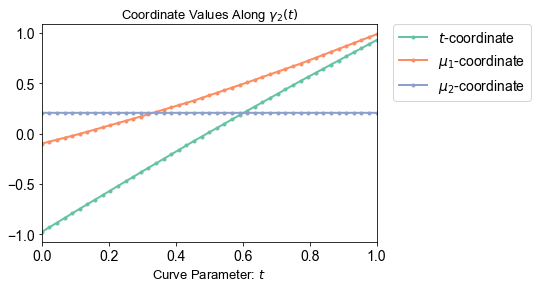

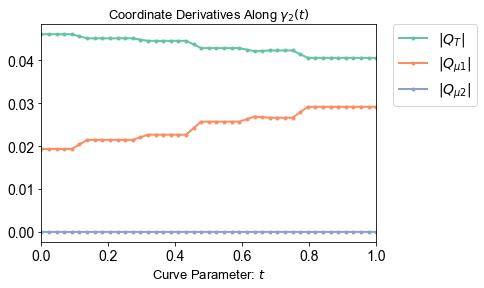

In [29]:
# Sample Q and gradQ values over parameter space
data = np.zeros_like(points)

for i in range(num):
  data[i] = map( lambda x: bg.burgers_witheps( 2, 256, 2000, nuPoints[i][x, 0], 1,
                                      nuPoints[i][x, 1:], 1, 0.001, False)[2:], range( len(nuPoints[i]) ) )

# Separate data appropriately
Qtwo = np.zeros_like(points)
gradQtwo = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]
nuGradsTwo = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]

for i in range(num):
  Qtwo[i] = np.array( [ data[i][j][0] for j in range( len(data[i]) ) ] )
  gradQtwo[i] = [ data[i][j][1] for j in range( len(data[i]) ) ]

# Chain rule to get appropriate gradients in [-1,1]^3
for i in range(num):
  nuGradsTwo[i] = 0.5 * (UBs - LBs) * gradQtwo[i]

# Build AM for visualization
am, fvals = nm.build_AM_from_data( nm.get_random_init_pt(3, 0),
                                  points[4], Qtwo[4], nuGradsTwo[4], 0.05)

nuAM = LBs + 0.5 * (UBs - LBs) * (1 + am)

# Coordinate Plot
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Values Along $\gamma_2(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues, am[:,0], '-o', c='#66c2a5',
         label = r'$t$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,1], '-o', c='#fc8d62',
         label = r'$\mu_1$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,2], '-o', c='#8da0cb',
         label = r'$\mu_2$-coordinate', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()

# Derivative Plot
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Derivatives Along $\gamma_2(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues,np.abs(np.gradient(am[:,0])), '-o', c='#66c2a5',
         label = r'$|Q_T|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,1])), '-o', c='#fc8d62',
         label = r'$|Q_{\mu1}|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,2])), '-o', c='#8da0cb',
         label = r'$|Q_{\mu2}|$', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()

### What if the parameter range is small?

We can also investigate this case using, say, the final time $t$.  Again, the behavior is as expected.

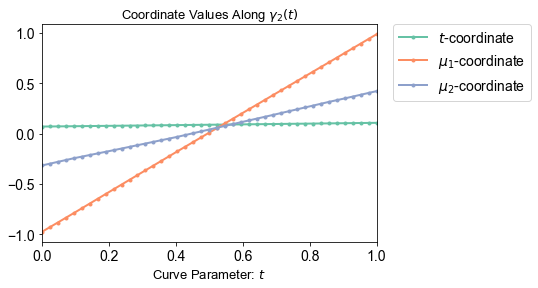

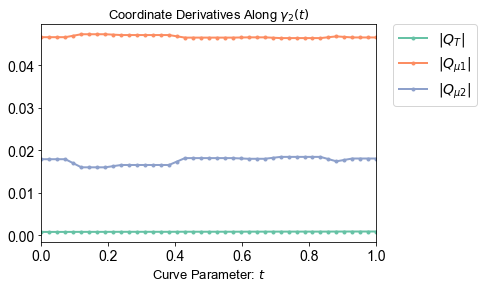

In [30]:
# T range is now quite narrow
UBs = np.array( [35.1, 5.5, 0.03] )
LBs = np.array( [34.9, 4.25, 0.015] )

# Linear scaling to appropriate range
nuPoints = np.zeros_like(points)

for i in range(num):
  nuPoints[i] = LBs + 0.5 * (UBs - LBs) * (1 + points[i])

# Sample Q and gradQ values over parameter space
data = np.zeros_like(points)

for i in range(num):
  data[i] = map( lambda x: bg.burgers( 2, 256, 2000, nuPoints[i][x, 0], 1,
                                      nuPoints[i][x, 1:], False)[2:], range( len(nuPoints[i]) ) )

# Separate data appropriately
Qtwo = np.zeros_like(points)
gradQtwo = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]
nuGradsTwo = [ [ 0 for col in range(3) ] for row in range( len(points) ) ]

for i in range(num):
  Qtwo[i] = np.array( [ data[i][j][0] for j in range( len(data[i]) ) ] )
  gradQtwo[i] = [ data[i][j][1] for j in range( len(data[i]) ) ]

# Chain rule to get appropriate gradients in [-1,1]^3
for i in range(num):
  nuGradsTwo[i] = 0.5 * (UBs - LBs) * gradQtwo[i]

# Build AM for visualization
am, fvals = nm.build_AM_from_data( nm.get_random_init_pt(3, 0),
                                  points[4], Qtwo[4], nuGradsTwo[4], 0.05)

nuAM = LBs + 0.5 * (UBs - LBs) * (1 + am)

# Coordinate Plot
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Values Along $\gamma_2(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues, am[:,0], '-o', c='#66c2a5',
         label = r'$t$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,1], '-o', c='#fc8d62',
         label = r'$\mu_1$-coordinate', markersize=3, linewidth=2)
plt.plot(sValues, am[:,2], '-o', c='#8da0cb',
         label = r'$\mu_2$-coordinate', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()

# Derivative Plot
numpts = len(am)
sValues = np.linspace(0., numpts, numpts) / numpts
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Coordinate Derivatives Along $\gamma_2(t)$', fontsize = 13)
ax.set_xlabel(r'Curve Parameter: $t$', fontsize = 13)
plt.plot(sValues,np.abs(np.gradient(am[:,0])), '-o', c='#66c2a5',
         label = r'$|Q_T|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,1])), '-o', c='#fc8d62',
         label = r'$|Q_{\mu1}|$', markersize=3, linewidth=2)
plt.plot(sValues,np.abs(np.gradient(am[:,2])), '-o', c='#8da0cb',
         label = r'$|Q_{\mu2}|$', markersize=3, linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1)
plt.show()